In [1]:
# Importando pacotes necessários
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

from scipy.stats import spearmanr

from collections import Counter

In [2]:
# Função para criar o modelo de rede neural
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(20, activation='relu', input_shape=(input_shape,)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Aplicando a seleção de Dados por k-fold

In [3]:
# Carregar o arquivo 'dados.csv' no dataframe
df_kfold = pd.read_csv('df_spearman_direto.csv')

In [4]:
# Separando as variáveis objetivo
X = df_kfold.drop('CLASSE', axis=1)
y = df_kfold['CLASSE']

In [5]:
#Definindo o número de folds

num_folds = 7
sub_num_folds = 7

In [6]:
#Configurar o k-Fold Principal

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [7]:
#Dividir os Dados para o k-fold teste

fold_indices = list(kf.split(X, y))

In [8]:
# Iterar sobre cada fold principal
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Aplicar o sub-k-fold para treino e validação
    sub_kf = StratifiedKFold(n_splits=sub_num_folds, shuffle=True, random_state=42)

    # Armazenar os índices dos folds secundários
    sub_fold_indices = list(sub_kf.split(X_train, y_train))

    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train.iloc[sub_train_index], y_train.iloc[sub_val_index]

        # Aqui você pode treinar e validar seu modelo
        # Exemplo: print(f'Fold {fold + 1}, Sub-Fold {sub_fold + 1}')


Testando disposição das Classes

In [9]:
# from collections import Counter
# import pandas as pd

# # Exemplo de dataframe com rótulos (alvo)
# y = pd.Series(y)  # Supondo que seus rótulos estejam em um array ou lista chamada 'y'

# # Inicializar o StratifiedKFold
# kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# # Iterar pelos folds principais
# for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Contagem das classes no treino e teste
#     train_counts = Counter(y_train)
#     test_counts = Counter(y_test)
    
#     # print(f"Fold {fold + 1}")
#     # print(f"Distribuição no treino: {train_counts}")
#     # print(f"Distribuição no teste: {test_counts}\n")


In [10]:
# # Aqui é só pra contar e ver a proporção dos Folds e Subfolds

# # Suponha que X seja um DataFrame e y seja uma Series
# # Se X é um DataFrame e y é uma Series
# kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# # Iterar pelos folds principais
# for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Contagem das classes no treino e teste
#     train_counts = Counter(y_train)
#     test_counts = Counter(y_test)
    
#     print(f"Fold {fold + 1}")
#     print(f"Distribuição no treino: {train_counts}")
#     print(f"Distribuição no teste: {test_counts}\n")

#     # Subdividir o treino em subfolds
#     sub_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    
#     for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_kfold.split(X_train, y_train)):
#         y_sub_train = y_train.iloc[sub_train_index]
#         y_sub_val = y_train.iloc[sub_val_index]
        
#         # Contagem das classes nos subfolds
#         sub_train_counts = Counter(y_sub_train)
#         sub_val_counts = Counter(y_sub_val)
        
#         print(f"  Subfold {sub_fold + 1}")
#         print(f"  Distribuição no treino: {sub_train_counts}")
#         print(f"  Distribuição na validação: {sub_val_counts}\n")



Aplicando as redes neurais no k-fold do PCA

In [11]:
# Lista para armazenar as métricas de avaliação
validation_reports = []

In [12]:
best_model_path = "best_model_spearman_direto.keras"  # Local para salvar o melhor modelo

# Configurar o callback para salvar o melhor modelo com base na métrica de validação
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Variável para armazenar o melhor desempenho
best_val_accuracy = 0
best_fold = None

In [13]:
# Inicializar uma lista para armazenar a precisão ponderada de cada fold
fold_accuracies = []

In [14]:
# # Exibir precisões ponderadas de cada fold
# for accuracy in fold_accuracies:
#     print(f"Fold {accuracy['fold']}, Sub-Fold {accuracy['sub_fold']}: Acurácia de Teste = {accuracy['test_accuracy']:.4f}")

In [15]:
# Codificar os rótulos para garantir que estejam no intervalo esperado
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [16]:
# Armazenar as precisões por classe para cada sub-fold
sub_fold_precisions = []

# Exibir a precisão de cada classe
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Aplicar Sub-K-Fold para treino e validação
    sub_fold_indices = list(sub_kf.split(X_train, y_train))
    
    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train[sub_train_index], y_train[sub_val_index]
        
        # Criar o modelo
        num_classes = len(label_encoder.classes_)
        model = create_model(X.shape[1], num_classes)
        
        # Treinar o modelo e salvar o histórico
        history = model.fit(
            X_sub_train, y_sub_train, 
            epochs=20, batch_size=32, 
            verbose=0, validation_data=(X_sub_val, y_sub_val),
            callbacks=[checkpoint]
        )

        # Avaliar no conjunto de teste
        y_test_pred = model.predict(X_test)
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)

        # Calcular acurácia de teste
        test_accuracy = np.mean(y_test_pred_classes == y_test)

        # Atualizar o melhor modelo se este fold for melhor
        if test_accuracy > best_val_accuracy:
            best_val_accuracy = test_accuracy
            best_fold = (fold, sub_fold)
        
        # Calcular a matriz de confusão
        cm = confusion_matrix(y_test, y_test_pred_classes, labels=np.arange(num_classes))
        
        # Calcular a precisão de cada classe
        class_precisions = precision_score(y_test, y_test_pred_classes, average=None)
        
        # Armazenar a precisão de cada classe para o sub-fold
        sub_fold_precisions.append({
            'fold': fold,
            'sub_fold': sub_fold,
            'precisions': class_precisions
        })

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B14A4B1E40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# # Exibir precisões de cada classe para cada sub-fold
# for sub_fold_precision in sub_fold_precisions:
#     print(f"Fold {sub_fold_precision['fold']}, Sub-Fold {sub_fold_precision['sub_fold']}:")
#     for i, precision in enumerate(sub_fold_precision['precisions']):
#         print(f"  Precisão da Classe {i}: {precision:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Melhor acurácia no fold 4, sub-fold 4: 0.8726114649681529


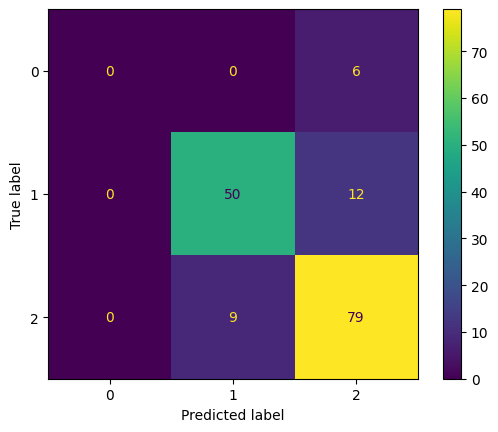

In [18]:
# Carregar o melhor modelo
best_model = load_model(best_model_path)

# Fazer previsões no conjunto de teste final
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Exibir a acurácia final do melhor modelo
print(f"Melhor acurácia no fold {best_fold[0]+1}, sub-fold {best_fold[1]+1}: {best_val_accuracy}")

In [19]:
# Gerar o relatório de classificação
report = classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_, output_dict=True)

# Converter o relatório em um DataFrame para exibição como matriz
report_df = pd.DataFrame(report).transpose()

# Exibir o relatório em formato de matriz
print("\nRelatório de Classificação (Matriz):")
print(report_df)

# Exibir a acurácia final do melhor modelo
print(f"\nMelhor acurácia no fold {best_fold[0]+1}, sub-fold {best_fold[1]+1}: {best_val_accuracy}")


Relatório de Classificação (Matriz):
              precision    recall  f1-score     support
Alta           0.000000  0.000000  0.000000    6.000000
Baixa          0.847458  0.806452  0.826446   62.000000
Media          0.814433  0.897727  0.854054   88.000000
accuracy       0.826923  0.826923  0.826923    0.826923
macro avg      0.553964  0.568060  0.560167  156.000000
weighted avg   0.796234  0.826923  0.810234  156.000000

Melhor acurácia no fold 4, sub-fold 4: 0.8726114649681529


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [20]:
# Calcular a matriz de confusão original
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Frequência das classes no conjunto de dados
class_counts = np.bincount(y_test)  # Conta o número de ocorrências de cada classe
class_weights = 1.0 / class_counts  # Calcula o peso de cada classe

# Matriz de confusão ponderada
weighted_conf_matrix = conf_matrix * class_weights[:, np.newaxis]

# Exibir a matriz de confusão ponderada
print("Matriz de Confusão Ponderada:")
print(weighted_conf_matrix)

# Calcular a precisão de cada classe
precisions = []
for i in range(weighted_conf_matrix.shape[0]):
    true_positives = weighted_conf_matrix[i, i]  # Verdadeiros Positivos
    false_positives = sum(weighted_conf_matrix[:, i]) - true_positives  # Falsos Positivos
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    precisions.append(precision)

# Exibir a precisão de cada classe
for idx, precision in enumerate(precisions):
    print(f'Precisão da Classe {idx}: {precision:.4f}')


Matriz de Confusão Ponderada:
[[0.         0.         1.        ]
 [0.         0.80645161 0.19354839]
 [0.         0.10227273 0.89772727]]
Precisão da Classe 0: 0.0000
Precisão da Classe 1: 0.8875
Precisão da Classe 2: 0.4293


In [21]:
# # Exibir precisões de cada classe para cada sub-fold
# for sub_fold_precision in sub_fold_precisions:
#     print(f"Fold {sub_fold_precision['fold']}, Sub-Fold {sub_fold_precision['sub_fold']}:")
#     for i, precision in enumerate(sub_fold_precision['precisions']):
#         print(f"  Precisão da Classe {i}: {precision:.4f}")

Guardando a precisão de cada classe

In [22]:
precisao_classe_A = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_A.append(sub_fold_precisions[i]['precisions'][0])

precisao_classe_B1 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_B1.append(sub_fold_precisions[i]['precisions'][1])

precisao_classe_B2 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_B2.append(sub_fold_precisions[i]['precisions'][2])

precisao_classe_C1 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_C1.append(sub_fold_precisions[i]['precisions'][3])

precisao_classe_C2 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_C2.append(sub_fold_precisions[i]['precisions'][4])

precisao_classe_DE = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_DE.append(sub_fold_precisions[i]['precisions'][5])


IndexError: index 3 is out of bounds for axis 0 with size 3

In [279]:
# #Histograma de precisão
# nbinsA = int(np.sqrt(len(precisao_classe_A)))
# plt.hist(precisao_classe_A, bins = nbinsA, edgecolor='black') 

In [ ]:
# Inicializar uma lista de listas para armazenar as precisões de cada classe
precisoes_classes = [[] for _ in range(6)]

# Preencher as listas com as precisões obtidas em cada sub-kfold
for i in range(len(sub_fold_precisions)):
    for classe in range(6):
        precisoes_classes[classe].append(sub_fold_precisions[i]['precisions'][classe])

# Calcular a média de precisão de cada classe
media_precisoes_classes = [sum(precisoes)/len(precisoes) for precisoes in precisoes_classes]
desvio_padrao_precisoes_classes = [statistics.stdev(precisoes) for precisoes in precisoes_classes]

# Exibir as médias de precisão de cada classe
vetor_classe = ["A", "B1", "B2", "C1", "C2", "DE"]
for classe, media in enumerate(media_precisoes_classes):
    # print(f"Classe {classe+1}: Média de Precisão = {media:.4f}")
    print(f"Classe {vetor_classe[classe]}: Média de Precisão = {media:.4f}, Desvio Padrão = {desvio:.4f}")